In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import wavelets

import os
import os.path

import datetime

In [2]:
def cyclotron_frequency(magnetic_field, element=1):
    proton_charge = -1.6 * 10**-19
    proton_mass = 1.67 * 10**-27
    coef = proton_charge / (2 * np.pi * element * proton_mass)
    cyclotron_data = np.abs(coef * (magnetic_field * 10**-9))
    return cyclotron_data

In [3]:
def wavelet(time_slice, b_slice, title='', xlabel='', log=True, save=False, filename='', element=1):
    x = b_slice.as_matrix()
    dt = time_slice.iloc[1] - time_slice.iloc[0]
    dt = float('.'.join([str(dt.seconds), str(dt.microseconds)]))
    wa = wavelets.WaveletAnalysis(x, dt=dt, dj=0.125, wavelet=wavelets.Morlet(), unbias=True)
    power = wa.wavelet_power
    scales = wa.scales
    t = wa.time
    
    # fig, (ax0, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 4]}, figsize=(7, 9))
    fig, (ax1, ax0, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 4]}, figsize=(7, 9))
    # fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios': [1, 4]}, figsize=(7, 9))
    
    ax1.set_title(title)    
    ax1.plot(time_slice, b_slice)
    ax1.xaxis.set_major_locator(mdates.SecondLocator(interval=960))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlim([time_slice.iloc[0], time_slice.iloc[-1]])
    ax1.set_xlabel('time, UT')
    ax1.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
    ax1.set_ylabel(xlabel)
    ax1.grid(True)
    
    C, S = wa.coi
    scales = np.array([s for s in scales if s < S.max()])
    
    # ax1.set_xlim([C.min(), C.max()])
    
    power = power[0:len(scales)]
    T, S = np.meshgrid(t, scales)
    
    vmin = power.min()
    vmax = power.max()
    
    if log:
        locator = ticker.LogLocator(numticks=64)
        norm = colors.LogNorm(vmin=vmin, vmax=vmax, clip=False)
    else:
        locator = ticker.LinearLocator(numticks=64)
        norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
    
#     np.set_printoptions(threshold=np.nan)
#     print(np.array2string(power, formatter={'float_kind':'{0:.3f}'.format}))
    
    Tt, St = wa.coi
    interpolated_coi = scipy.interpolate.interp1d(Tt, St, bounds_error=False)
    
    cyclotron_period = 1 / cyclotron_frequency(x, element)
    cyclotron_period[cyclotron_period > interpolated_coi(t)] = np.nan
    
    def find_nearest_idx(array, value):
        idx = (np.abs(array - value)).argmin()
        return idx

    tt = np.arange(0.0, len(t))
    ss = np.array([find_nearest_idx(scales, x) for x in cyclotron_period], dtype=float)
    
    ss[ss == 0] = np.nan
    cyclotron_power = scipy.ndimage.map_coordinates(power, np.vstack((ss, tt)), order=0)    
    cyclotron_power[cyclotron_power == 0] = np.nan
    
    # test2 = pd.DataFrame({'time': time_slice, 'power': cyclotron_power})
    # test2.to_csv(title + '.csv', index=False)
    
    ax0.set_title('Power on cyclotron frequency')    
    ax0.semilogy(time_slice, cyclotron_power)
    
    ax0.xaxis.set_major_locator(mdates.SecondLocator(interval=960))
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax0.set_xlim([time_slice.iloc[0], time_slice.iloc[-1]])
    ax0.set_xlabel('time, UT')
    ax0.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
    ax0.set_ylabel('Power, (nT)^2')
    ax0.grid(True)
    
    s = ax2.contourf(T, S, power, np.arange(vmin, vmax, 0.001), locator=locator, norm=norm, vmin=vmin, vmax=vmax)
    ax2.set_xlabel('time, UT')
    
    def wavelet_date_formatter(x, pos):
        return (time_slice[0] + datetime.timedelta(0, float(x))).strftime('%H:%M')
    
    formatter = ticker.FuncFormatter(wavelet_date_formatter)
    ax2.get_xaxis().set_major_formatter(formatter)
    ax2.grid(b=True, which='major', color='k', linestyle='--', alpha=.5, zorder=3)
    
    C, S = wa.coi
    
    ax2.set_ylabel('scale, s')
    ax2.set_yscale('log')
    ax2.set_ylim(scales.max(), scales.min())
    # ax2.set_yticks([1, 5, 10, 15, 30, 60, 120, 240])
    ax2.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    # ax2.set_xlim([time_slice.iloc[0], time_slice.iloc[-1]])
    ax2.fill_between(x=C, y1=S, y2=scales.max(), color='gray', alpha=0.3)
    
    ax2.plot(t, cyclotron_period, 'r-', linewidth=1)
    
    cb = fig.colorbar(s, ax=ax2, orientation='horizontal', pad=0.12, extend='both')
    cb.set_label('Wavelet power spectrum, (nT)^2')
    cb.set_clim(vmin=vmin, vmax=vmax)
    
    ax_fourier = ax2.twinx()
    
    ax_fourier.set_yscale('log')
    ax_fourier.set_yticks([10**-1, 10**-2, 5*10**-3, 10**-3])
    ax_fourier.set_ylabel('frequency, Hz')
    
    fourier_lim = [1/wa.fourier_period(i) for i in ax2.get_ylim()]
    ax_fourier.set_ylim(fourier_lim)
    
    if save:
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
        plt.close()
        
    else:
        plt.tight_layout()
        plt.show()
        plt.close()

In [4]:
filename = '200713_00-03_Bgse_full_4.txt'
filename = '200713_00_Bgsm_p3_high.asc'

path = os.path.join(r'c:\Users\moon\Documents\me\science\grant_data\pre\200713', filename)

In [9]:
path = r'c:\Users\moon\Documents\me\science\grant_data\jupiter\jupiter_converted'
jupiter_converted = [f for f in os.listdir(path)]

for plasmoid_event in jupiter_converted[0]:
    filename = plasmoid_event
    full_path = os.path.join(path, filename)

    names = ['time', 'Bmag']

    data = pd.read_csv(full_path, sep='\t')
    data.time = pd.to_datetime(data.time, unit='s')

    log = False
    prefix = 'log' if log else 'linear'
    save = False
    b = 'Bmag'

    element = 'proton'

    multiple = 16

    fname = '{}_{}_{}'.format(os.path.splitext(filename)[0], b, element)
    
    wavelet(data.time, data[b], title=fname, xlabel='{}, nT'.format(b), log=log, save=save, filename=fname, element=multiple)

FileNotFoundError: File b'c:\\Users\\moon\\Documents\\me\\science\\grant_data\\jupiter\\jupiter_converted\\1' does not exist

In [7]:
names = ['t', 'dt', 'Bx', 'By', 'Bz', 'B', 'X', 'Y', 'Z', 'GSE', '']
bgse_c1 = pd.read_csv(path, header=None, names=names, skiprows=2)
bgse_c1.t = pd.to_datetime(bgse_c1.t, format='%Y-%m-%dT%H:%M:%S.%fZ')

In [5]:
names = ['t', 'Bx', 'By', 'Bz', 'B']
bgse_c1 = pd.read_csv(path, header=None, names=names)
bgse_c1.t = pd.to_datetime(bgse_c1.t, format='%Y %m %d %H %M %S.%f')

C:\Users\moon\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: RuntimeWarning: invalid value encountered in greater


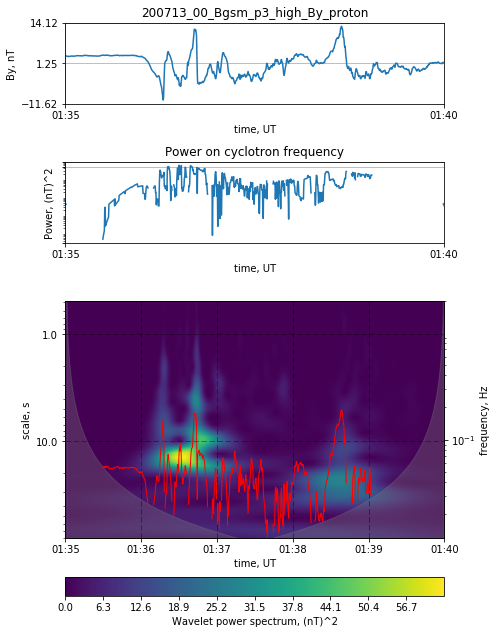

In [7]:
# mpl.rcParams['figure.figsize'] = [8.0, 6.0]
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['savefig.dpi'] = 100

# mpl.rcParams['font.size'] = 12
# mpl.rcParams['legend.fontsize'] = 'large'
# mpl.rcParams['figure.titlesize'] = 'medium'

log = False
prefix = 'log' if log else 'linear'
save = False
b = 'By'
start = 22000
# start = 0
end = start + 1000
# end = bgse_c1.shape[0] - start - 1

element = 'proton'

multiple = 1

fname = '{}_{}_{}'.format(os.path.splitext(filename)[0], b, element)

data = bgse_c1[start:end].reset_index()
wavelet(data.t, data[b], title=fname, xlabel='{}, nT'.format(b), log=log, save=save, filename=fname, element=multiple)

# fig, ax = plt.subplots()
#
# ax.plot(bgse_c1.t, bgse_c1[b])
# ax.plot(data.t, data[b])
# ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1200))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_xlabel('time, UT')
# ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
# ax.set_ylabel('')
# ax.grid(True)
#
# if save:
#     plt.savefig('{}_{}_{}_slice'.format(os.path.splitext(filename)[0], b, event))
#     plt.close()

In [ ]:
log = False
prefix = 'log' if log else 'linear'
save = False

for start, event, n in [(0, 0, bgse_c1.shape[0]), (21500, 1, 5000)]:
    for element, multiple in [('proton', 1), ('helium', 4), ('oxygen', 16)]:
        for b in ['B', 'Bx', 'By', 'Bz']:
            fname = '{}_{}_{}_{}'.format(os.path.splitext(filename)[0], b, event, element)

            data = bgse_c1[start:start + n].reset_index()
            wavelet(data.t, data[b], title=fname, xlabel='{}, nT'.format(b), log=log, save=save, filename=fname, element=multiple)

#             fig, ax = plt.subplots()

#             ax.plot(bgse_c1.t, bgse_c1[b])
#             ax.plot(data.t, data[b])
#             ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1200))
#             ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#             ax.set_xlabel('time, UT')
#             ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
#             ax.set_ylabel('')
#             ax.grid(True)

#             if save:
#                 plt.savefig('{}_{}_{}_slice'.format(os.path.splitext(filename)[0], b, event))
#                 plt.close()

C:\Users\moon\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: RuntimeWarning: invalid value encountered in greater
